# **Modeling the mind of a predator: Interactive cognitive maps support flexible avoidance of dynamic threats**

### Toby Wise, Caroline J Charpentier, Peter Dayan & Dean Mobbs

## Analysis notebook 4 - Tree search planning models

This notebook contains code for modelling of subjects' movements using monte carlo tree search (MCTS) models

In [2]:
import pandas as pd
import seaborn as sns
import os
import pingouin as pg
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
from maMDP.env_io import *
from maMDP.env_io import hex_environment_from_dict
import sys
sys.path.append("../../code") 
import matplotlib
matplotlib.style.use('toby')
matplotlib.rcParams['font.weight'] = 'normal'
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams["font.family"] = "Heebo"

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.5, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Load in data

In [10]:
response_dfs = []

output_dir = '../../data/'
experiment = 'experiment-2'

data_dfs = {'response_data': response_dfs}

for data_type, df_list in data_dfs.items():
    
    data_type_dir = os.path.join(output_dir, data_type, experiment)
    
    conditions = os.listdir(data_type_dir)
    
    for c in conditions:
        for i in os.listdir(os.path.join(data_type_dir, c)):
            if '.csv' in i:
                df = pd.read_csv(os.path.join(data_type_dir, c, i))
                df_list.append(df)

response_df = pd.concat(response_dfs)
response_df = response_df.sort_values(['agent', 'subjectID', 'exp', 'condition', 'env', 'trial', 'response_number']).reset_index(drop=True)
response_df = response_df[response_df['subjectID'].isin(response_df['subjectID'].unique()[:80])]

## Load environment data

In [15]:
envs = {}
for cond in ['A']:
    with open('../../data/game_info/experiment-2/condition_{0}.json'.format(cond), 'r') as f:
        game_info = json.load(f)
    envs[cond] = [hex_environment_from_dict(env, ['Dirt', 'Trees', 'Reward']) for env in game_info['environments']]

#### Remove training and practice environments

In [16]:
envs['A'] = envs['A'][2:]
response_df = response_df[response_df['env'] > 1]

### Get predator/prey data

In [17]:
predator_df = response_df[response_df['agent'] == 'predator']
prey_df = response_df[response_df['agent'] == 'prey']

## Plot environments

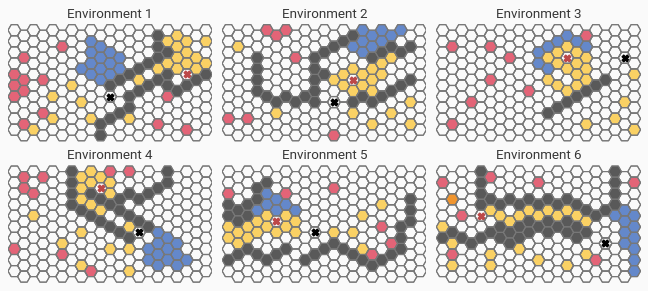

In [18]:
n_envs = len(envs['A'])

f, ax = plt.subplots(2, 3, figsize=(10, 4))

for env in range(n_envs):
    
    envs['A'][env].plot(ax=ax[int(env / 3), env % 3], agent_plotting_kwargs={'s': 40}, agent_colours={'Predator_1': '#bd4848'}, colours=['#003cab', '#d40020', '#fab700'], alphas=[0.6] * 4)
    ax[int(env / 3), env % 3].set_title('Environment {0}'.format(env + 1))

plt.subplots_adjust(wspace=-0.2)
plt.savefig('../../figures/final2/Figure-4_Exp2_environments.svg')

## Get state occupancy

In [19]:
from maMDP.plotting import plot_hex_grid_values, plot_hex_grids

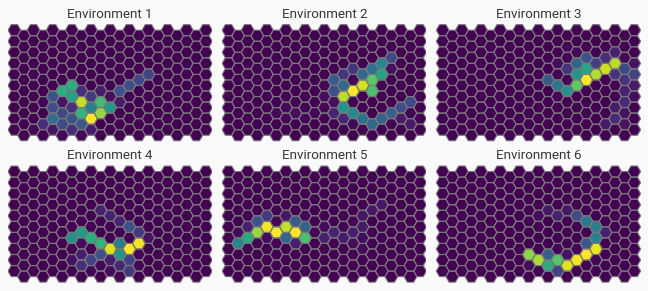

In [20]:
n_envs = len(envs['A'])

occupancy_arrays = []

f, ax = plt.subplots(2, 3, figsize=(10, 4))

for env in range(n_envs):
    
    env_state_occupancy = np.zeros(envs['A'][env].mdp.shape)
    
    for state in prey_df.loc[prey_df['env'] == env + 2, 'cellID'].tolist():
        if state >= 0:
            env_state_occupancy[envs['A'][env].mdp.state_to_idx(state)] += 1
        
    occupancy_arrays.append(env_state_occupancy)
    
    plot_hex_grid_values(env_state_occupancy, ax=ax[int(env / 3), env % 3])
    ax[int(env / 3), env % 3].set_title('Environment {0}'.format(env + 1))
    
plt.subplots_adjust(wspace=-0.2)
plt.savefig('../../figures/final2/Figure-4_Exp2_state_occupancy.svg')

## Get time spent in rich reward zone

In [22]:
rich_reward_states = {
    1: [135, 156, 166, 168, 176, 177, 178, 179, 186, 187, 188, 196, 197, 206, 208],
    2: [134, 136, 144, 145, 154, 155, 156, 165, 166, 177],
    3: [115, 117, 124, 126, 127, 134, 136, 138, 144, 145, 146, 147, 155, 156, 157],
    4: [77, 78, 79, 86, 88, 89, 96, 99, 107, 108, 124],
    5: [3, 4, 13, 14, 23, 24, 34, 35, 44, 45, 54, 64, 65, 74, 75],
    6: [56, 65, 75, 85, 96, 105, 116, 125, 136, 145, 155]
}

prey_df['rich_reward'] = np.nan

for env in range(n_envs):    
    prey_df.loc[prey_df['env'] == env + 2, 'rich_reward'] = prey_df.loc[prey_df['env'] == env + 2, 'cellID'].isin(rich_reward_states[env + 1]).astype(int)

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [23]:
entered_rich_reward = prey_df.groupby(['env', 'subjectID']).max().reset_index()
proportion_entered = entered_rich_reward.groupby(['env']).mean().reset_index()

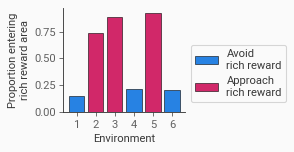

In [27]:
plt.figure(figsize=(3.7, 2))

plt.bar([0, 3, 5], proportion_entered['rich_reward'][[0, 3, 5]], label='Avoid\nrich reward', linewidth=.5, edgecolor='black')
plt.bar([1, 2, 4], proportion_entered['rich_reward'][[1, 2, 4]], label='Approach\nrich reward', linewidth=.5, edgecolor='black')
plt.legend(bbox_to_anchor=(1, .7), loc='upper left')
plt.ylabel('Proportion entering\nrich reward area')
plt.xlabel('Environment')
plt.xticks(range(6), range(1, 7))
plt.tight_layout()
sns.despine()
plt.savefig('../../figures/Figure-4_Exp2_proportion_rich_reward.svg')

### Chi-squared test of proportions

In [28]:
from scipy.stats import chisquare
x2, p = chisquare([entered_rich_reward[entered_rich_reward['env'].isin([1, 2, 5])]['rich_reward'].sum(), entered_rich_reward[entered_rich_reward['env'].isin([3, 4, 6])]['rich_reward'].sum()])

print('X2(2) = {0}, p = {1}'.format(np.round(x2, 2), np.round(p, 50)))

X2(2) = 131.44, p = 1.986038521523681e-30


## Model fitting predictions

This represents the pattern of model fit we expect to see across the different conditions.

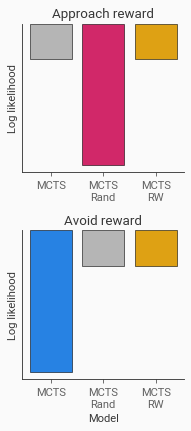

In [29]:
model_names = ['MCTS', 'MCTS\nRand', 'MCTS\nRW']

# Enter the rich rewards
y1 = [-0.2, -0.8, -0.2]

# Avoid rich rewards
y2 = [-0.8, -0.2, -0.2]

f, ax = plt.subplots(2, 1, figsize=(2.5, 5.5))

ax[0].bar(model_names, y1, color=['#b5b5b5', pal[1], pal[2]], linewidth=.5, edgecolor='black')
ax[0].set_ylabel('Log likelihood')
ax[0].set_title('Approach reward')
ax[0].set_yticks([])

ax[1].bar(model_names, y2, color=[pal[0], '#b5b5b5', pal[2]], linewidth=.5, edgecolor='black')
ax[1].set_ylabel('Log likelihood')
ax[1].set_xlabel('Model')
ax[1].set_title('Avoid reward')
ax[1].set_yticks([])

plt.tight_layout()
sns.despine()

plt.savefig('../../figures/Figure-4_Exp2_predicted_modelling_results.svg')

## Set up model fitting

This creates a dataframe with the parameter values we want to test using [Inverse Binomial Sampling](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008483).

In [30]:
C_values = [1, 5, 10, 20, 50]
C_values = [5]
models = ['MCTS', 'MCTS_interactive', 'MCTS_interactive_random'] 

from itertools import product

param_list = list(product(models, C_values))
param_list.append(('null_model', -1))
planning_model_params = pd.DataFrame(param_list, columns=['model', 'C'])
planning_model_params['softmax_temperature'] = -1
planning_model_params['experiment'] = 2
planning_model_params['condition'] = 'A'
planning_model_params['n_moves'] = 4
planning_model_params['max_planning_steps'] = 8  # Total number of moves

sub_param_dfs = []

for sub in prey_df['subjectID'].unique():
    sub_param_df = planning_model_params.copy()
    sub_param_df['subjectID'] = sub
    sub_param_dfs.append(sub_param_df)
    
planning_model_params = pd.concat(sub_param_dfs).reset_index(drop=True)

# planning_model_params.to_csv('../../data/planning_model_fit_runs.csv', index=False)

## Model fitting

All the MCTS models are fit using the `run_mcts_IBS_fit.py` script in the `~/code` directory. This is fairly computationally intensive, so this procedure is run independently of this notebook to take advantage of HPC parallel computing.

## Load in model fits

In [35]:
fit_dir = '../../data/IBS_fits/experiment_2/condition_A/'

fits = pd.concat([pd.read_csv(os.path.join(fit_dir, i)) for i in os.listdir(fit_dir)])

fits = fits[fits['subjectID'].isin(response_df['subjectID'].tolist())]

fits['avoid_rich_reward'] = fits['environment'].isin([2, 5, 7])
fits_sum = fits[(fits['model'] != 'null_model') & (fits['environment'] != 1) & (fits['C'] == 5)].groupby(['subjectID', 'model', 'avoid_rich_reward']).sum().reset_index()
rename_dict = dict(zip(['MCTS', 'MCTS_interactive_random', 'MCTS_interactive'], model_names))

### Run t-tests to test key hypotheses about model fit

In [38]:
nsubs = len(fits_sum.loc[(fits_sum['model'] == 'MCTS_interactive_random') & (fits_sum['avoid_rich_reward'] == False), 'll'])
t, p = ttest_rel(fits_sum.loc[(fits_sum['model'] == 'MCTS_interactive_random') & (fits_sum['avoid_rich_reward'] == False), 'll'], fits_sum.loc[(fits_sum['model'] == 'MCTS_interactive') & (fits_sum['avoid_rich_reward'] == False), 'll'])
print('t({0})={1}, p={2}, d={3}'.format(nsubs-1, t, p*2, pg.compute_effsize_from_t(t, N=nsubs, eftype='cohen')))

t(79)=-7.971244520538215, p=1.9836770159014677e-11, d=-1.7824244613196165


In [39]:
t, p = ttest_rel(fits_sum.loc[(fits_sum['model'] == 'MCTS') & (fits_sum['avoid_rich_reward'] == True), 'll'], fits_sum.loc[(fits_sum['model'] == 'MCTS_interactive') & (fits_sum['avoid_rich_reward'] == True), 'll'])
print('t({0})={1}, p={2}, d={3}'.format(nsubs-1, t, p*2, pg.compute_effsize_from_t(t, N=nsubs, eftype='cohen')))

t(79)=-7.168894665532721, p=7.092258914943105e-10, d=-1.6030135795666782


### Plot predicted and observed model fit

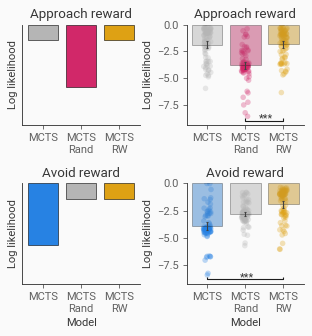

In [45]:
# Enter the rich rewards
y1 = [-0.2, -0.8, -0.2]

# Avoid rich rewards
y2 = [-0.8, -0.2, -0.2]

f, ax = plt.subplots(2, 2, figsize=(4, 4.3))

ax[0, 0].bar(model_names, y1, color=['#b5b5b5', pal[1], pal[2]], linewidth=.5, edgecolor='black')
ax[0, 0].set_ylabel('Log likelihood')
ax[0, 0].set_title('Approach reward')
ax[0, 0].set_yticks([])
ax[0, 0].set_ylim(-1.3, 0)

ax[1, 0].bar(model_names, y2, color=[pal[0], '#b5b5b5', pal[2]], linewidth=.5, edgecolor='black')
ax[1, 0].set_ylabel('Log likelihood')
ax[1, 0].set_xlabel('Model')
ax[1, 0].set_title('Avoid reward')
ax[1, 0].set_yticks([])
ax[1, 0].set_ylim(-1.3, 0)

sns.stripplot(x='model', y='ll', data=fits_sum[fits_sum['avoid_rich_reward'] == False].replace(rename_dict), order=model_names, ax=ax[0, 1], palette=['#b5b5b5', pal[1], pal[2]], alpha=0.3, zorder=-1)
sns.barplot(x='model', y='ll', data=fits_sum[fits_sum['avoid_rich_reward'] == False].replace(rename_dict), order=model_names, ax=ax[0, 1], palette=['#b5b5b5', pal[1], pal[2]], alpha=0.5, capsize=.05, errwidth=1, linewidth=.5, edgecolor='black')
ax[0, 1].set_xlabel('')
ax[0, 1].set_ylabel('Log likelihood')
ax[0, 1].set_title('Approach reward')

min_ll = fits_sum.loc[fits_sum['avoid_rich_reward'] == False, 'll'].min()
y_offset = -.2
ax[0, 1].plot([1, 1, 2, 2], [min_ll+y_offset, min_ll+y_offset-.2, min_ll+y_offset-.2, min_ll+y_offset], color='#1c1c1c')
ax[0, 1].text(1.35, min_ll+y_offset-.25, '***')

sns.stripplot(x='model', y='ll', data=fits_sum[fits_sum['avoid_rich_reward'] == True].replace(rename_dict), order=model_names, ax=ax[1, 1], palette=[pal[0], '#b5b5b5', pal[2]], alpha=0.3, zorder=-1)
sns.barplot(x='model', y='ll', data=fits_sum[fits_sum['avoid_rich_reward'] == True].replace(rename_dict), order=model_names, ax=ax[1, 1], palette=[pal[0], '#b5b5b5', pal[2]], alpha=0.5, capsize=.05, errwidth=1, linewidth=.5, edgecolor='black')
ax[1, 1].set_ylabel('Log likelihood')
ax[1, 1].set_xlabel('Model')
ax[1, 1].set_title('Avoid reward')

min_ll = fits_sum.loc[fits_sum['avoid_rich_reward'] == True, 'll'].min()
y_offset = -.2
ax[1, 1].plot([0, 0, 2, 2], [min_ll+y_offset, min_ll+y_offset-.2, min_ll+y_offset-.2, min_ll+y_offset], color='#1c1c1c')
ax[1, 1].text(.85, min_ll+y_offset-.25, '***')


plt.tight_layout()
sns.despine()

plt.savefig('../../figures/Figure-4_Exp2_predicted_observed_modelling_results.svg')